# Trans-Effects

## Install necessary Packages

In [1]:
!pip install cptac
!pip install --upgrade cptac

Requirement already up-to-date: cptac in c:\users\chels\anaconda3\lib\site-packages (0.8.0)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
import pyensembl
from scipy import stats

## Download all the data

In [3]:
cptac.download(dataset="luad")
cptac.download(dataset="hnscc")
cptac.download(dataset="ovarian")
cptac.download(dataset="colon")
cptac.download(dataset="brca")
cptac.download(dataset="lscc")

True

In [4]:
luad = cptac.Luad()
hnscc = cptac.Hnscc()
ovarian = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
lscc = cptac.Lscc()

cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 1)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 2)


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 6)


In [5]:
luad_cnv = luad.get_CNV()
hnscc_cnv = hnscc.get_CNV()
ovarian_cnv =  ovarian.get_CNV()
colon_cnv = colon.get_CNV()
brca_cnv = brca.get_CNV()
lscc_cnv = lscc.get_CNV()

In [6]:
luad_prot = luad.get_proteomics()
hnscc_prot = hnscc.get_proteomics()
ovarian_prot = ovarian.get_proteomics()
colon_prot = colon.get_proteomics()
brca_prot = brca.get_proteomics()
lscc_prot = lscc.get_proteomics()

In [7]:
# Used to find the gene locations
ensembl = pyensembl.EnsemblRelease()

## Create Counts Table

In [8]:
def separate(hiCut, lowCut, data):
  """
  Counts the Number of patients with high and low value for each gene.
  """
  sepDict = dict()
  for column in data:
    numHi = 0
    numLow = 0
    numNeu = 0
    for i in data[column]:
        if i > hiCut:
            numHi += 1
        elif i < lowCut:
            numLow += 1
        else:
            numNeu += 1 
    sepDict[column] = [numHi, numNeu, numLow]
  return sepDict

In [9]:
def get_counts_and_average(data):
  """
  Takes a CNV dataframe and generates a dataframe with the counts of high, low and neutral values
  """
  df = pd.DataFrame(data = separate(.3,-.2,data), index = ["amplifications", "neutral", "deletions"])
  df = df.append(pd.DataFrame(data.mean(0), columns=['average']).transpose(), sort=True)
  return df.transpose()

In [10]:
def add_chromo_and_loc(my_dict):
    chromo = list()
    locations = list()
    not_found = list()
    count = 0
    for gene in list(my_dict.index.get_level_values(0)):
        count += 1
        try:
            e_gene = ensembl.genes_by_name(gene)
            chromo.append(e_gene[0].contig)
            locations.append((e_gene[0].start + e_gene[0].end)/2)
        except:
            not_found.append(gene)
            chromo.append(None)
            locations.append(None)
    my_dict['chromo'] = chromo
    my_dict['location'] = locations
#     my_dict['cancer'] = cancer
    print(len(not_found)/count)
    return my_dict

In [11]:
luad_counts = get_counts_and_average(luad_cnv)
hnscc_counts = get_counts_and_average(hnscc_cnv)
ovarian_counts = get_counts_and_average(ovarian_cnv)
colon_counts = get_counts_and_average(colon_cnv)
brca_counts = get_counts_and_average(brca_cnv)
lscc_counts = get_counts_and_average(lscc_cnv)

In [14]:
luad_counts = add_chromo_and_loc(luad_counts)
hnscc_counts = add_chromo_and_loc(hnscc_counts)
ovarian_counts = add_chromo_and_loc(ovarian_counts)
colon_counts = add_chromo_and_loc(colon_counts)
brca_counts = add_chromo_and_loc(brca_counts)
lscc_counts = add_chromo_and_loc(lscc_counts)

0.037577204546634144
0.019470286208123633
0.05881324318022849
0.1250645174097749
0.09678372446395407
0.016476616265635204


In [15]:
luad_counts['cancer'] = "LUAD"
hnscc_counts['cancer'] = "HNSCC"
ovarian_counts['cancer'] = 'OVARIAN'
colon_counts['cancer'] = "COLON"
brca_counts['cancer'] = "BRCA"
lscc_counts['cancer'] = "LSCC"

## Specify a Chromosome

In [16]:
chromosome_num = '8'

In [17]:
# Drop any genes that we don't have a location for
luad_counts_cleaned = luad_counts.dropna(subset=['location'])
hnscc_counts_cleaned = hnscc_counts.dropna(subset=['location'])
ovarian_counts_cleaned = ovarian_counts.dropna(subset=['location'])
colon_counts_cleaned = colon_counts.dropna(subset=['location'])
brca_counts_cleaned = brca_counts.dropna(subset=['location'])
lscc_counts_cleaned = lscc_counts.dropna(subset=['location'])

In [18]:
luad_counts_cleaned_8 = luad_counts_cleaned[luad_counts_cleaned.chromo==chromosome_num]
hnscc_counts_cleaned_8 = hnscc_counts_cleaned[hnscc_counts_cleaned.chromo==chromosome_num]
ovarian_counts_cleaned_8 = ovarian_counts_cleaned[ovarian_counts_cleaned.chromo==chromosome_num]
colon_counts_cleaned_8 = colon_counts_cleaned[colon_counts_cleaned.chromo==chromosome_num]
brca_counts_cleaned_8 = brca_counts_cleaned[brca_counts_cleaned.chromo==chromosome_num]
lscc_counts_cleaned_8 = lscc_counts_cleaned[lscc_counts_cleaned.chromo==chromosome_num]

## Create Graphs

In [19]:
# This is the cutoff value (determined by experimentation) that we are using for the event
insertion_event_start = 80794385.5
insertion_event_end = 130794385.5

In [20]:
luad_counts_8 = pd.melt(luad_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
hnscc_counts_8 = pd.melt(hnscc_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
ovarian_counts_8 = pd.melt(ovarian_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
colon_counts_8 = pd.melt(colon_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
brca_counts_8 = pd.melt(brca_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])
lscc_counts_8 = pd.melt(lscc_counts_cleaned_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])

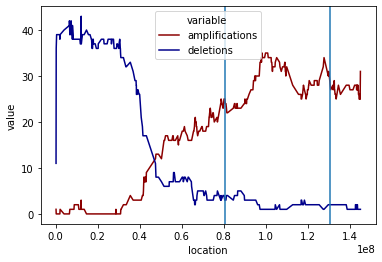

In [21]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=luad_counts_8)
plt.axvline(insertion_event_start)
plt.axvline(insertion_event_end)

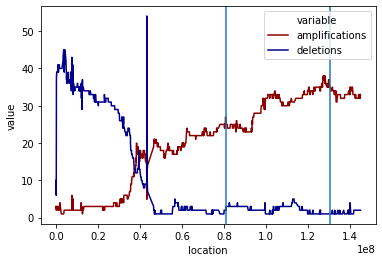

In [22]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=hnscc_counts_8)
plt.axvline(insertion_event_start)
plt.axvline(insertion_event_end)

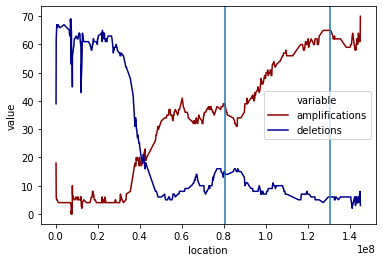

In [23]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=ovarian_counts_8)
plt.axvline(insertion_event_start)
plt.axvline(insertion_event_end)

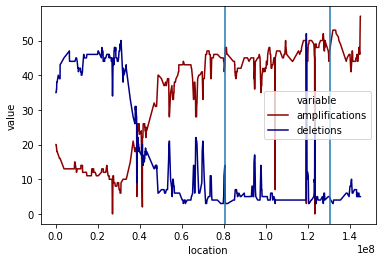

In [24]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=colon_counts_8)
plt.axvline(insertion_event_start)
plt.axvline(insertion_event_end)

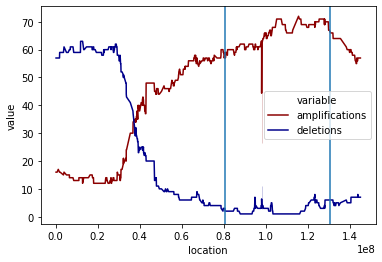

In [25]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=brca_counts_8)
plt.axvline(insertion_event_start)
plt.axvline(insertion_event_end)

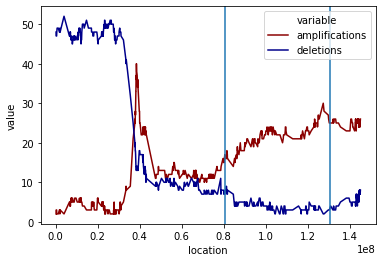

In [26]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=lscc_counts_8)
plt.axvline(insertion_event_start)
plt.axvline(insertion_event_end)

## Get Genes before Event

In [27]:
def calc_percent(row):
    values = list(row)
    return(len([x for x in values if x >= 0.2]) / len(values))

In [28]:
# brca_gene_list, brca_gene_database_ids = zip(*brca_gene_list)

In [29]:
luad_gene_list = list(luad_counts_cleaned_8[luad_counts_cleaned_8.location > insertion_event_start][luad_counts_cleaned_8.location < insertion_event_end].index)
hnscc_gene_list = list(hnscc_counts_cleaned_8[hnscc_counts_cleaned_8.location > insertion_event_start][hnscc_counts_cleaned_8.location < insertion_event_end].index)
ovarian_gene_list = list(ovarian_counts_cleaned_8[ovarian_counts_cleaned_8.location > insertion_event_start][ovarian_counts_cleaned_8.location < insertion_event_end].index)
colon_gene_list = list(colon_counts_cleaned_8[colon_counts_cleaned_8.location > insertion_event_start][colon_counts_cleaned_8.location < insertion_event_end].index)
brca_gene_list = list(brca_counts_cleaned_8[brca_counts_cleaned_8.location > insertion_event_start][brca_counts_cleaned_8.location < insertion_event_end].index)
lscc_gene_list = list(lscc_counts_cleaned_8[lscc_counts_cleaned_8.location > insertion_event_start][lscc_counts_cleaned_8.location < insertion_event_end].index)

C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key

In [30]:
# brca_gene_list, brca_gene_database_ids = zip(*brca_gene_list)

In [31]:
# all_genes_in_event = list(set().union(luad_gene_list, hnscc_gene_list, ovarian_gene_list, colon_gene_list, brca_gene_list, lscc_gene_list))

In [34]:
# print(all_genes_in_event)

In [35]:
brca_cnv

Name                      7SK                                      \
Database_ID ENSG00000232512.2 ENSG00000249352.3 ENSG00000254144.2   
Patient_ID                                                          
CPT000814              -0.058            -0.496             0.466   
CPT001846               0.065            -0.126             0.148   
X01BR001                1.036            -0.309             1.265   
X01BR008                0.090             0.372             0.602   
X01BR009                0.375            -0.135             3.657   
...                       ...               ...               ...   
X21BR001               -0.069            -0.109             1.047   
X21BR002               -0.443             0.408             0.053   
X21BR010                0.238             0.282             0.012   
X22BR005                0.015             0.072             0.160   
X22BR006                0.365            -0.006             0.335   

Name                                                               \
Database_ID ENSG00000260682.2 ENSG00000271765.1 ENSG00000271818.1   
Patient_ID                                                          
CPT000814               0.058             0.453            -1.019   
CPT001846              -0.197            -0.132             0.273   
X01BR001                0.060             0.020            -0.058   
X01BR008               -0.060             0.115            -0.091   
X01BR009               -0.122            -0.138             0.104   
...                       ...               ...               ...   
X21BR001               -0.259             0.136            -0.289   
X21BR002               -0.458            -0.061            -0.009   
X21BR010               -0.324            -0.003            -0.016   
X22BR005               -0.290             0.083            -0.291   
X22BR006               -0.445             0.027            -0.001   

Name                     A1BG              A1CF                A2M  \
Database_ID ENSG00000121410.7 ENSG00000148584.9 ENSG00000175899.10   
Patient_ID                                                           
CPT000814              -0.396             0.006              1.089   
CPT001846              -0.187             0.000             -0.146   
X01BR001               -0.111            -0.051             -0.132   
X01BR008                0.059             0.238              0.509   
X01BR009                0.661            -0.126             -0.126   
...                       ...               ...                ...   
X21BR001               -0.183             0.060              0.104   
X21BR002                0.098            -0.004              0.008   
X21BR010                0.203            -0.008             -0.281   
X22BR005                0.029             0.079              0.075   
X22BR006               -0.029             0.052             -0.012   

Name                     A2ML1  ...           snoZ185           snoZ247  \
Database_ID ENSG00000166535.15  ... ENSG00000252672.1 ENSG00000252281.1   
Patient_ID                      ...                                       
CPT000814                1.089  ...            -0.475             0.031   
CPT001846               -0.146  ...             1.401            -0.096   
X01BR001                -0.132  ...             0.243             0.173   
X01BR008                 0.509  ...             0.177             0.107   
X01BR009                -0.126  ...             1.093             0.377   
...                        ...  ...               ...               ...   
X21BR001                 0.104  ...             0.132             0.000   
X21BR002                 0.008  ...            -0.086            -0.001   
X21BR010                -0.281  ...             0.279            -0.015   
X22BR005                 0.075  ...            -0.101            -0.109   
X22BR006                -0.012  ...             0.388            -0.017   

Name                  snoZ278     

In [36]:
luad_df_before_event = luad_cnv[luad_gene_list]
hnscc_df_before_event = hnscc_cnv[hnscc_gene_list]
ovarian_df_before_event = ovarian_cnv[ovarian_gene_list]
colon_df_before_event = colon_cnv[colon_gene_list]
brca_df_before_event = brca_cnv[brca_gene_list]
lscc_df_before_event = lscc_cnv[lscc_gene_list]

In [37]:
brca_gene_list, brca_gene_database_ids = zip(*brca_gene_list)
all_genes_in_event = list(set().union(luad_gene_list, hnscc_gene_list, ovarian_gene_list, colon_gene_list, brca_gene_list, lscc_gene_list))

In [38]:
luad_df_before_event['percent'] = luad_df_before_event.apply(calc_percent, axis=1)
hnscc_df_before_event['percent'] = hnscc_df_before_event.apply(calc_percent, axis=1)
ovarian_df_before_event['percent'] = ovarian_df_before_event.apply(calc_percent, axis=1)
colon_df_before_event['percent'] = colon_df_before_event.apply(calc_percent, axis=1)
brca_df_before_event['percent'] = brca_df_before_event.apply(calc_percent, axis=1)
lscc_df_before_event['percent'] = lscc_df_before_event.apply(calc_percent, axis=1)

C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [39]:
luad_df_before_event

Name,AARD,ABRA,ANGPT1,ANKRD46,ANXA13,ASAP1,ATAD2,ATP6V0D2,ATP6V1C1,AZIN1,...,WDYHV1,WWP1,YWHAZ,ZFAND1,ZFPM2,ZHX1,ZHX2,ZNF572,ZNF706,percent
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00001,0.2465,0.2710,0.2710,0.9111,0.2465,0.2379,0.2465,0.2379,0.9111,0.9111,...,0.2465,0.2379,0.9111,-0.0510,0.7149,0.2465,0.2465,0.2465,0.9111,0.923529
C3L-00009,0.1353,0.1353,0.1353,0.1353,0.1353,0.1353,0.1353,0.1353,0.1353,0.1353,...,0.1353,0.1353,0.1353,0.1490,0.1353,0.1353,0.1353,0.1353,0.1353,0.000000
C3L-00080,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,...,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,0.2276,1.000000
C3L-00083,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,...,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.0324,0.000000
C3L-00093,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,...,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,-0.0118,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-02729,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,...,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,0.2680,1.000000
X11LU013,1.7162,1.6158,1.0356,1.6999,1.9229,2.0949,1.9229,1.4070,1.6999,1.6999,...,1.9229,1.2774,1.6999,1.5233,1.4927,1.9229,2.0650,2.1335,1.6999,1.000000
X11LU016,-0.0182,-0.0182,-0.0182,-0.0209,-0.0182,-0.0120,-0.0182,-0.0209,-0.0209,-0.0209,...,-0.0182,-0.0209,-0.0209,-0.0209,-0.0306,-0.0182,-0.0182,-0.0182,-0.0209,0.000000


## Group Samples

In [40]:
luad_has_event = list(luad_df_before_event[luad_df_before_event.percent > .8].index)
hnscc_has_event = list(hnscc_df_before_event[hnscc_df_before_event.percent > .8].index)
ovarian_has_event = list(ovarian_df_before_event[ovarian_df_before_event.percent > .8].index)
colon_has_event = list(colon_df_before_event[colon_df_before_event.percent > .8].index)
brca_has_event = list(brca_df_before_event[brca_df_before_event.percent > .8].index)
lscc_has_event = list(lscc_df_before_event[lscc_df_before_event.percent > .8].index)

In [41]:
luad_no_event = [x for x in luad_df_before_event.index if x not in luad_has_event]
hnscc_no_event = [x for x in hnscc_df_before_event.index if x not in hnscc_has_event]
ovarian_no_event = [x for x in ovarian_df_before_event.index if x not in ovarian_has_event]
colon_no_event = [x for x in colon_df_before_event.index if x not in colon_has_event]
brca_no_event = [x for x in brca_df_before_event.index if x not in brca_has_event]
lscc_no_event = [x for x in lscc_df_before_event.index if x not in lscc_has_event]

In [42]:
gene_lists = {'LUAD': {'has_event': luad_has_event, 'no_event': luad_no_event},
             'HNSCC': {'has_event': hnscc_has_event, 'no_event': hnscc_no_event},
             'OVARIAN': {'has_event': ovarian_has_event, 'no_event': ovarian_no_event},
             'COLON': {'has_event': colon_has_event, 'no_event': colon_no_event},
             'BRCA': {'has_event': brca_has_event, 'no_event': brca_no_event},
             'LSCC': {'has_event': lscc_has_event, 'no_event': lscc_no_event}}

In [43]:
print("LUAD")
print("Yes", len(luad_has_event), "No", len(luad_no_event))
print("HNSCC")
print("Yes", len(hnscc_has_event), "No", len(hnscc_no_event))
print("OVARIAN")
print("Yes", len(ovarian_has_event), "No", len(ovarian_no_event))
print("COLON")
print("Yes", len(colon_has_event), "No", len(colon_no_event))
print("BRCA")
print("Yes", len(brca_has_event), "No", len(brca_no_event))
print("LSCC")
print("Yes", len(lscc_has_event), "No", len(lscc_no_event))

LUAD
Yes 32 No 77
HNSCC
Yes 40 No 69
OVARIAN
Yes 41 No 59
COLON
Yes 47 No 58
BRCA
Yes 63 No 59
LSCC
Yes 31 No 79


## Run T Tests

In [44]:
def t_test(col, cancer):
    has_ev = col[col.index.isin(gene_lists[cancer]['has_event'])]
    no_ev = col[col.index.isin(gene_lists[cancer]['no_event'])]
    return stats.ttest_ind(has_ev, no_ev, equal_var=True)

In [45]:
luad_t_test = luad_prot.apply(lambda x: t_test(x, "LUAD")).transpose()
hnscc_t_test = hnscc_prot.apply(lambda x: t_test(x, "HNSCC")).transpose()
ovarian_t_test = ovarian_prot.apply(lambda x: t_test(x, "OVARIAN")).transpose()
colon_t_test = colon_prot.apply(lambda x: t_test(x, "COLON")).transpose()
brca_t_test = brca_prot.apply(lambda x: t_test(x, "BRCA")).transpose()
lscc_t_test = lscc_prot.apply(lambda x: t_test(x, "LSCC")).transpose()

C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\chels\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [46]:
hnscc_t_test = hnscc_t_test.to_frame()
hnscc_t_test['hnscc_stat'] = [x[0] for x in hnscc_t_test[0]]
hnscc_t_test['hnscc_pvalue'] = [x[1] for x in hnscc_t_test[0]]

In [47]:
colon_t_test = colon_t_test.to_frame()
colon_t_test['colon_stat'] = [x[0] for x in colon_t_test[0]]
colon_t_test['colon_pvalue'] = [x[1] for x in colon_t_test[0]]

In [48]:
luad_t_test = luad_t_test.rename(columns={0:"luad_stat", 1:"luad_pvalue"})
ovarian_t_test = ovarian_t_test.rename(columns={0:"ovarian_stat", 1:"ovarian_pvalue"})
brca_t_test = brca_t_test.rename(columns={0:"brca_stat", 1:"brca_pvalue"})
lscc_t_test = lscc_t_test.rename(columns={0:"lscc_stat", 1:"lscc_pvalue"})

In [49]:
colon_t_test = colon_t_test.drop([0], axis=1)
hnscc_t_test = hnscc_t_test.drop([0], axis=1)

In [50]:
# Rename the database_id in the tables with multiindex
luad_t_test.index = luad_t_test.index.rename("Database_ID_Luad", level=1)
ovarian_t_test.index = ovarian_t_test.index.rename("Database_ID_Ovarian", level=1)
brca_t_test.index = brca_t_test.index.rename("Database_ID_Brca", level=1)
lscc_t_test.index = lscc_t_test.index.rename("Database_ID_Lscc", level=1)

In [51]:
# colon_t_test[5:53]

In [52]:
# colon_t_test.drop(["AARD"], axis=1)

KeyError: "['AARD'] not found in axis"

In [53]:
# luad_t_test_trans = luad_t_test.drop(all_genes_in_event, level="Name")
# ovarian_t_test_trans = ovarian_t_test.drop(all_genes_in_event, level="Name")
# brca_t_test_trans = brca_t_test.drop(all_genes_in_event, level="Name")
# lscc_t_test_trans = lscc_t_test.drop(all_genes_in_event, level="Name")
# colon_t_test_trans = colon_t_test.drop(colon_gene_list)
# hnscc_t_test_trans = hnscc_t_test.drop(hnscc_gene_list)

KeyError: "['AARD' 'ABRA' 'ANGPT1' 'ANKRD46' 'ASAP1-IT2' 'ATP6V0D2' 'AZIN1' 'BAALC'\n 'C8orf37' 'C8orf76' 'C8orf87' 'CASC8' 'CCAT2' 'CCNE2' 'CNBD1' 'CNGB3'\n 'CSMD3' 'DCAF4L2' 'DCSTAMP' 'DPY19L4' 'DPYS' 'E2F5' 'ENPP2' 'ERICH5'\n 'EXT1' 'FABP12' 'FABP9' 'FAM83A' 'FAM83A-AS1' 'FBXO32' 'FBXO43' 'FER1L6'\n 'FER1L6-AS1' 'FER1L6-AS2' 'FSBP' 'FZD6' 'GDF6' 'GEM' 'GSDMC' 'HAS2'\n 'HAS2-AS1' 'KCNS2' 'KCNV1' 'KLF10' 'KLHL38' 'LAPTM4B' 'LINC00534'\n 'LINC00535' 'LINC00536' 'LINC00861' 'LINC00964' 'LINC01030' 'LRP12'\n 'LRRC69' 'LRRCC1' 'MAL2' 'MIR1204' 'MIR1205' 'MIR1206' 'MIR1207'\n 'MIR1208' 'MIR2053' 'MIR3150A' 'MIR3150B' 'MIR3151' 'MIR3610' 'MIR378D2'\n 'MIR4471' 'MIR4661' 'MIR4663' 'MIR5194' 'MIR548A3' 'MIR548AA1' 'MIR548AZ'\n 'MIR5680' 'MIR599' 'MIR6844' 'MIR7705' 'MIR8084' 'MIR875' 'MMP16' 'MTBP'\n 'MYC' 'NECAB1' 'NIPAL2' 'ODF1' 'OSGIN2' 'OSR2' 'PCAT1' 'PKHD1L1' 'PMP2'\n 'POU5F1B' 'PRNCR1' 'PSKH2' 'PVT1' 'RAD21-AS1' 'RAD54B' 'RBM12B-AS1'\n 'REXO1L2P' 'RGS22' 'RIMS2' 'RNF139' 'RNF139-AS1' 'RNF19A' 'RSPO2'\n 'RUNX1T1' 'SAMD12' 'SAMD12-AS1' 'SLC10A5' 'SLC26A7' 'SLC30A8' 'SLC7A13'\n 'SNORA72' 'SNX31' 'TAF2' 'TBC1D31' 'TMEM64' 'TMEM67' 'TMEM74' 'TMEM75'\n 'TNFRSF11B' 'TP53INP1' 'TRHR' 'TRIB1' 'TRMT12' 'TRPS1' 'TSPYL5' 'VPS13B'\n 'WDYHV1' 'ZFPM2' 'ZHX1' 'ZNF572'] not found in axis"

In [68]:
results = colon_t_test.join(brca_t_test).join(luad_t_test).join(hnscc_t_test).join(ovarian_t_test).join(lscc_t_test)

In [69]:
pd.set_option('display.max_rows', 10)


In [71]:
results_with_loc = add_chromo_and_loc(results)

0.020038473869830074


In [72]:
# luad_counts_cleaned_8.location > insertion_event_start][luad_counts_cleaned_8.location < insertion_event_end
#                                                         

In [73]:
print(type(insertion_event_end))

<class 'float'>


In [74]:
def test(x):
    a = x['chromo'] != '8'
    b = x['location'] < insertion_event_start
    c = x['location'] > insertion_event_end
    print(a,b,c, a|b|c)
    return a|b|c
  

In [75]:
results_trans = results_with_loc[results_with_loc.apply(lambda x: test(x), axis=1)]

True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False True True
True True False True
True False False True
True True False True
True False False True
True False False True
True True False True
True True False True
True True False True
True False False True
True False True True
True False True True
True True False True
True True False True
True False True True
True True False True
True True False True
True False False True
True False False True
True False True True
True False False True
True False True True
True True False True
True False True True
True False True True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True False False True
Tru

True False False True
True False False True
True False False True
True False True True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
Tru

True False False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True False True True
True True False True
True False True True
True False True True
True True False True
True True False True
False False True True
True True False True
True True False True
True False False True
True False True True
True True False True
True True False True
True False True True
True False True True
True False True True
True False True True
True True False True
True True False True
True False True True
True False False True
True True False True
True False True True
True False True True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True False True True
True True False True
True False False True
True Fa

True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False False True
True False False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
False True False True
False True False True
False True False True
False True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True False False True
True True False True
False True False True
False True False True
True False True True
True True False True
True True False True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
T

True False True True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True True False True
True True False True
True True False True
True False True True
True False True True
True False True True
True False True True
True True False True
True False True True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False False True
True True False True
False False False False
True False False True
True True False True
True False False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False True True
True False False True
True False False True
True False False True
True False False True
True False True Tru

True True False True
True False False True
True True False True
True True False True
True False True True
True True False True
True True False True
True False True True
True True False True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
True False True True
True False True True
False False False False
True True False True
True True False True
False True False True
False True False True
True False True True
True True False True
True False False True
True False False True
False False True True
True True False 

False False True True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False True True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True False False True
True True False True
True False True True
True False True True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True False False True
True False True True
True False True True
True True False True
False True False True
True True False True
True False True True
True True False True
True False True True
True False True True
True False True True
True False True True
True Fal

True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True False False True
True True False True
True False False True
True False True True
True True False True
True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True False False True
True True False True
True False True True
True True False True
True False False True
True False False True
True True False True
False False False False
False False False False
False False False False
False False False False
True False True True
True True False True
True False False True
True True False True
True True False True
False False True True
True False False True
True False False True
True False True True
True True False True
True True False True
False False False False
True False False True
True False False True
True True False True
True True False Tru

True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True False False True
True False False True
True True False True
True True False True
True False True True
True False True True
True False False True
True True False True
True False True True
True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False Fa

True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
False True False True
True True False True
True True False True
True False False True
True False True True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True False False True
True True False True
True True False True
True False False True
True True False True
True False False True
True False False True
False True False True
True True False True
True True False True
True True False True
True False False True
True True False True
T

True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True 

True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True True 

True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True False False True
True False True True
True False False True
True True False True
True True False True
True False False True
True True False True
False True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True False True True
True True False True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True Tr

True False False True
True False False True
True True False True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False True True
True False True True
True False True True
True False False True
True False False True
True False True True
True True False True
True False True True
True False True True
True True False True
True False True True
True False False True
True False False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False True True
True False True True
True False True True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
Tr

True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True 

True False True True
True False False True
True False True True
True False True True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True False True True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
False False True True
True True False True
True False False True
True False False True
True False False True
True True False True
True True False True
True False True True
True True False True
True False True True
True True False True
True True False True
True False True True
False True False True
True True False True
False False False False
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False T

True False False True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
True False True True
False False False False
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True False True True
True True False True
True False False True
True True False True
True False True True
True True False True
True True False True
True T

False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False False True True
False Fals

True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False True True
True False True True
True False True True
True False False True
True True False True
True True False True
True False True True
True False True True
True False False True
True False True True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True False False True
True False False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True Tru

True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True Fal

True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True False True True
True False False True
True True False True
True False True True
False True False True
True True False True
True False False True
False True False True
True False True True
True False True True
True True False True
True False False True
True False False True
True True False True
True True False True
True False False True
True True False True
False True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False False True
True False False True
True False False True
True True False True
True False False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False True Tru

True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True False False True
True True False True
True True False True
True True False True
True False True True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True False False True
True True False True
True False True True
True False True True
True False True True
True False True True
True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True False True True
True True False True
True False False True
False True False True
True True False True


True False True True
True False True True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True True False True
True False False True
True True False True
False True False True
True False False True
True True False True
True False True True
True True False True
True False False True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True True False True
True True False True
True False True True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True False False True
True False False True
True False True True
True True False True
True False False True
Tr

True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True Fals

True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True True False True
True True False True
False False False False
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
False False False False
True True False True
True True False True
True False False True
True False False True
True True False True
True False True True
True False False True
True False False True
True True False True
True False False True
True True False True
True True False True
True False False True
True True False True
True False True True
True False True True
True True False True
True False True True
True True False True
True True False True
True True False True
True True False Tru

True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False False True
True False False True
True False False True
True False False True
True False False True
True True False True
True True False True
True True False True
True False True True
False True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True

True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False False True
True False

True True False True
True True False True
True True False True
True True False True
True False False True
True False True True
True False True True
True True False True
True True False True
True False False True
True True False True
True True False True
True False False True
True False False True
True False False True
True True False True
True False True True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True False False True
True False False True
True False True True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True

True False True True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True False True True
True False False True
True False False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True True False True
True False False True
True True False True
True True False True
True True False True
True True False True
True False True True
True False False True
True False True True
True False False True
True False False True
True True False True
True True False True
False True False True
True False True True
True True False True
False True False True
False True False True
True True False True
Tr

In [76]:
luad_trans_proteins = list(set(results_trans[results_trans.luad_pvalue <= 0.05].index.get_level_values(0)))
ovarian_trans_proteins = list(set(results_trans[results_trans.ovarian_pvalue <= 0.05].index.get_level_values(0)))
hnscc_trans_proteins = list(set(results_trans[results_trans.hnscc_pvalue <= 0.05].index.get_level_values(0)))
colon_trans_proteins = list(set(results_trans[results_trans.colon_pvalue <= 0.05].index.get_level_values(0)))
brca_trans_proteins = list(set(results_trans[results_trans.brca_pvalue <= 0.05].index.get_level_values(0)))
lscc_trans_proteins = list(set(results_trans[results_trans.lscc_pvalue <= 0.05].index.get_level_values(0)))

In [77]:
results = results.drop(all_genes_in_event, level="Name")

In [79]:
luad_proteins = list(set(luad_t_test[luad_t_test.luad_pvalue < 0.05].index.get_level_values(0)))
hnscc_proteins = list(set(hnscc_t_test[hnscc_t_test.hnscc_pvalue < 0.05].index.get_level_values(0)))
ovarian_proteins = list(set(ovarian_t_test[ovarian_t_test.ovarian_pvalue < 0.05].index.get_level_values(0)))
colon_proteins = list(set(colon_t_test[colon_t_test.colon_pvalue < 0.05].index.get_level_values(0)))
brca_proteins = list(set(brca_t_test[brca_t_test.brca_pvalue < 0.05].index.get_level_values(0)))
lscc_proteins = list(set(lscc_t_test[lscc_t_test.lscc_pvalue < 0.05].index.get_level_values(0)))

In [80]:
len(set(lscc_proteins)) % len(lscc_proteins) 

0

In [81]:
aliases = ['MYC', 'CMYC', 'MYCC', "MRTL", 'BHLHE39']

In [82]:
luad_prot[luad_prot.columns[luad_prot.columns.get_level_values(0).str.startswith('MYC')]].columns.get_level_values(0)

Index(['MYCBP', 'MYCBP2'], dtype='object', name='Name')

In [83]:
def CountFrequency(my_list): 
  """
  Counts the frequency of the gene in the given list.
  Returns a list of genes that appeared 3 or more times.
  """
  freq = {} 
  for items in my_list: 
      freq[items] = my_list.count(items) 
  sig = []
  for key, value in freq.items(): 
    if value == 5:
        print(key, value)
        sig.append(key)
  return sig

In [84]:
common_proteins = CountFrequency(luad_trans_proteins +
                                hnscc_trans_proteins +
                                ovarian_trans_proteins +
                                colon_trans_proteins +
                                brca_trans_proteins +
                                lscc_trans_proteins)

UFL1 5
PML 5
PRKCB 5
ARHGDIB 5
NDRG1 5
SLIRP 5
CAMK1 5
PPP3CB 5
SNX17 5
ICAM1 5
UTP14A 5
SERPINB1 5
GTPBP10 5
TIMM13 5
STAU2 5
DNPEP 5
PRKDC 5
TOMM22 5
BOP1 5
ARFGEF1 5
HGH1 5
SERPINB6 5
MTPAP 5
MRPL19 5
MRPL53 5
HSF1 5
MRPL15 5


In [104]:
def all_low_pvalues(row):
    return ((row['luad_pvalue'] < 0.1) & (row['ovarian_pvalue'] < 0.1) & (row['hnscc_pvalue'] < 0.1) & (row['colon_pvalue'] < 0.1) & (row['brca_pvalue'] < 0.1) & (row['lscc_pvalue'] < 0.1))

In [105]:
common_low_pvalues = results[results.apply(lambda x: all_low_pvalues(x), axis=1)]

In [106]:
common_low_pvalues

,,,,,colon_stat,colon_pvalue,brca_stat,brca_pvalue,luad_stat,luad_pvalue,hnscc_stat,hnscc_pvalue,ovarian_stat,ovarian_pvalue,lscc_stat,lscc_pvalue,chromo,location
Name,Database_ID_Brca,Database_ID_Luad,Database_ID_Ovarian,Database_ID_Lscc,,,,,,,,,,,,,,
AGO2,NP_036286.2|NP_001158095.1,NP_036286.2|NP_001158095.1,NP_036286,NP_036286.2|NP_001158095.1,4.730994,7.949419e-06,3.756759,2.670869e-04,4.246124,0.000047,2.212576,0.029092,2.838620,0.005757,2.120324,0.036268,8,140577894.5
ARFGEF1,NP_006412.2,NP_006412.2,NP_006412,NP_006412.2,6.076534,2.671349e-08,3.574828,5.059482e-04,5.093374,0.000002,4.806029,0.000005,1.791794,0.076995,2.679935,0.008517,8,67258646.0
C8orf82,NP_001001795.1,NP_001001795.1,NP_001001795,NP_001001795.1,6.455946,4.825319e-09,4.734886,6.058338e-06,3.433263,0.000849,2.304765,0.023147,3.550410,0.000652,3.023726,0.003120,8,144527432.5
GGH,NP_003869.1,NP_003869.1,NP_003869,NP_003869.1,4.109798,8.524800e-05,3.656261,3.811428e-04,2.760380,0.006795,4.029827,0.000106,2.476578,0.015401,3.560391,0.000552,8,63026942.5
GTPBP10,NP_149098.2|NP_001036182.1,NP_149098.2|NP_001036182.1,NP_149098,NP_149098.2|NP_001036182.1,3.006235,3.400672e-03,3.995672,1.117306e-04,2.380180,0.019074,3.187884,0.001889,1.977353,0.051490,2.067704,0.041058,7,90363339.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAB43,NP_001191815.1|NP_001191816.1|NP_001191817.1,NP_001191812.1|NP_001191816.1|NP_001191817.1,NP_001191815,NP_001191812.1|NP_001191816.1|NP_001191817.1,-2.276395,2.511647e-02,-2.512405,1.331855e-02,-2.208165,0.029366,-1.886791,0.061951,-1.950370,0.054679,-2.373009,0.019412,3,129105185.0
RRS1,NP_055984.1,NP_055984.1,NP_055984,NP_055984.1,3.821197,2.397274e-04,3.620247,4.322438e-04,2.262126,0.025710,2.324558,0.022020,2.004091,0.048488,2.769755,0.006605,8,66429873.5
SCRIB,NP_874365.3,NP_874365.3,NP_056171,NP_874365.3,5.312601,7.356816e-07,5.179258,9.095080e-07,4.735468,0.000007,3.093123,0.002538,4.095673,0.000101,4.097059,0.000081,8,143803346.5


In [107]:
common_low_pvalues_cleaned = common_low_pvalues.drop(columns=['chromo', 'location'])

In [108]:
common_low_pvalues_cleaned.index = common_low_pvalues_cleaned.index.droplevel([1,2,3,4])

In [109]:
!pip install scinot

In [115]:
import scinot
import six

In [111]:
common_low_pvalues_cleaned = common_low_pvalues_cleaned.applymap(lambda x: scinot.format(x, 3) )

In [112]:
common_low_pvalues_cleaned.reset_index(inplace=True)

In [113]:
# This is not my code. Found at https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image/39358722
def render_mpl_table(data, col_width=2.2, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

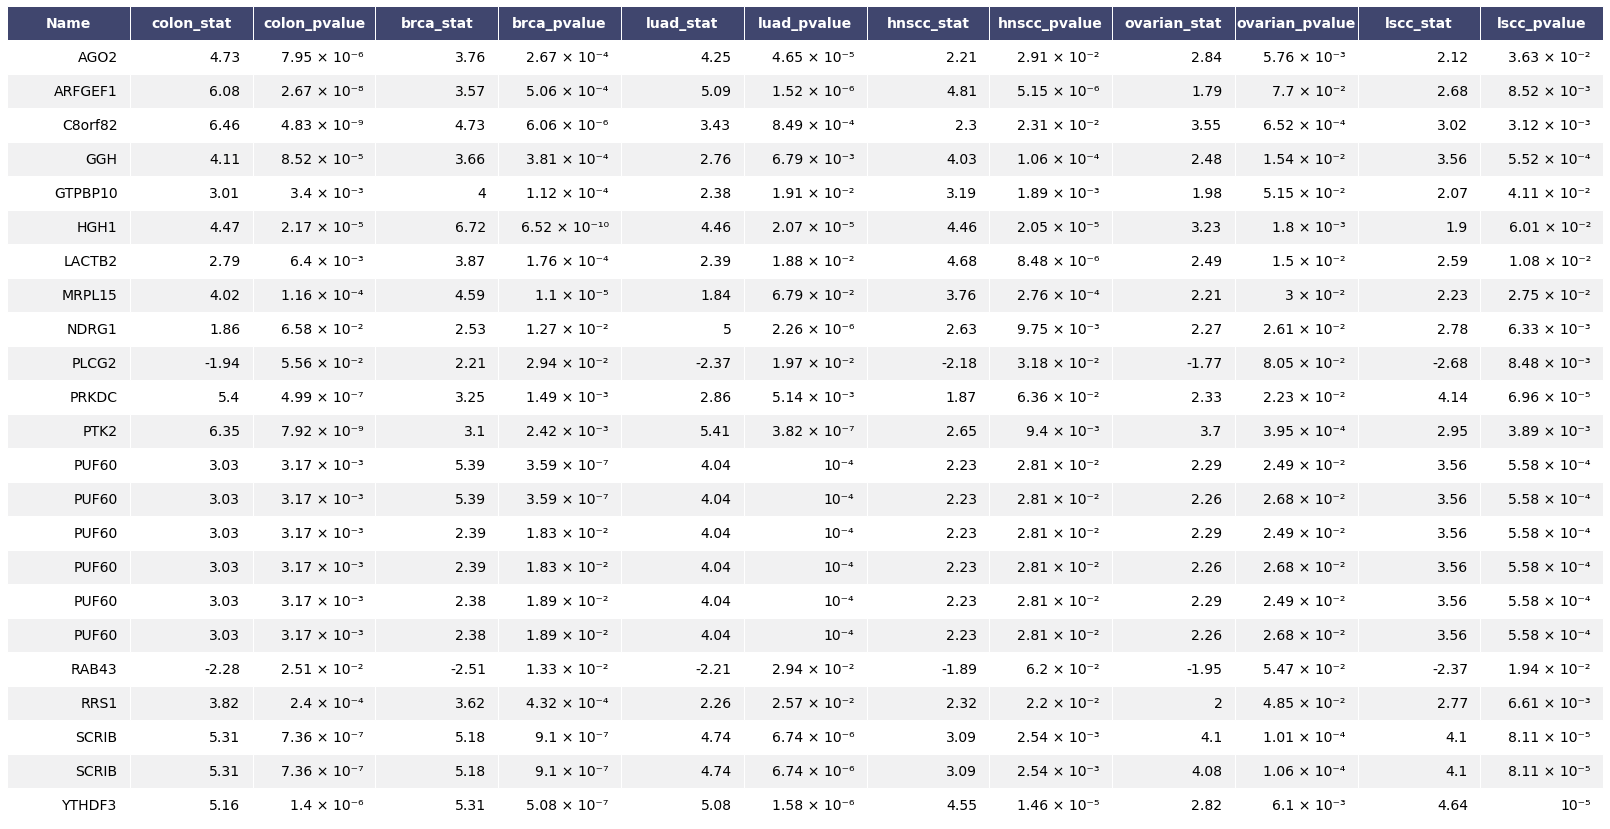

In [116]:
render_mpl_table(common_low_pvalues_cleaned)